In [1]:
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [2]:
train = train.sample(frac=1).reset_index(drop=True)
test = test.sample(frac=1).reset_index(drop=True)

In [3]:
train = train.dropna()
test = test.dropna()

In [4]:
print(train.shape, test.shape)
train.head()

(24000, 2) (6000, 2)


,x,y
0,"갈색,병,좋다,같다,최고",색상
1,"번째,구매,배송도,빠르다,색상,이쁘다",색상
2,"특가,저렴하다,구매하다,구매하다,재구매,하게만,들다,다음,용량,크다,도해,쓰겠습디나...",용량
3,"잇츠스킨,프레스티지,로씨옹,진생,데스까르고,잇츠스킨,프레스티지,로씨옹,진행,데스까르...",가격
4,"이쁘다,좋다,배송,빠르다",디자인


In [5]:
train_corpus = []
for words in train['x']:
    a = []
    a.append(words)
    train_corpus.append(a)
    
test_corpus = []
for words in test['x']:
    a = []
    a.append(words)
    test_corpus.append(a)

In [6]:
train_corpus[:2]

[['갈색,병,좋다,같다,최고'], ['번째,구매,배송도,빠르다,색상,이쁘다']]

In [7]:
train_token_review = []
for corpus in train_corpus:
    c = corpus[0].split(",")
    train_token_review.append(c)
        
test_token_review = []
for corpus in test_corpus:
    c = corpus[0].split(",")
    test_token_review.append(c)

In [8]:
train_token_review[:2]

[['갈색', '병', '좋다', '같다', '최고'], ['번째', '구매', '배송도', '빠르다', '색상', '이쁘다']]

In [9]:
from collections import namedtuple

TaggedDocument = namedtuple('TaggedDocument', 'words tags')

In [10]:
from gensim.models.doc2vec import Doc2Vec

tagged_train_docs = [TaggedDocument(d, c) for d, c in zip(train_token_review, train['y'].values)]
tagged_test_docs = [TaggedDocument(d, c) for d, c in zip(test_token_review, test['y'].values)]

In [11]:
tagged_train_docs[:2]

[TaggedDocument(words=['갈색', '병', '좋다', '같다', '최고'], tags='색상'),
 TaggedDocument(words=['번째', '구매', '배송도', '빠르다', '색상', '이쁘다'], tags='색상')]

In [12]:
tagged_test_docs[:2]

[TaggedDocument(words=['고급스럽다', '보이다', '입자', '곱다'], tags='디자인'),
 TaggedDocument(words=['오프라인', '저렴하다', '구매하다', '어성초', '성분', '맞다', '사용하다', '배송', '빠르다'], tags='가격')]

In [13]:
doc_vectorizer = Doc2Vec(dm=0,
                         min_count=3,
                         vector_size=256, 
                         window=5,
                         negative=20)

In [14]:
doc_vectorizer.build_vocab(tagged_train_docs)

In [16]:
from time import time

start = time()
for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, total_examples=doc_vectorizer.corpus_count, epochs=doc_vectorizer.iter)
    doc_vectorizer.alpha -= 0.002 # decrease the learning rate
    doc_vectorizer.min_alpha = doc_vectorizer.alpha # fix the learning rate, no decay
end = time()
print("During Time: {}".format(end-start))

c:\users\battl\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `iter` (Attribute will be removed in 4.0.0, use self.epochs instead).
  """


During Time: 121.66170525550842


In [17]:
X_train = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
y_train = [doc.tags for doc in tagged_train_docs]

In [18]:
X_test = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
y_test = [doc.tags for doc in tagged_test_docs]

In [19]:
X_train_np = np.asarray(X_train)
X_test_np = np.array(X_test)

In [20]:
y_train_np = np.asarray(y_train, dtype=str)
y_test_np = np.asarray(y_test, dtype=str)

In [21]:
print(X_train_np.shape)
print(X_test_np.shape)

(24000, 256)
(6000, 256)


In [22]:
print(y_train_np.shape)
print(y_test_np.shape)

(24000,)
(6000,)


In [23]:
y_test_np

array(['디자인', '가격', '용량', ..., '색상', '향기', '가격'], dtype='<U3')

In [24]:
target_names = list(set(y_test_np))
target_mapping_table = {}
for idx, names in enumerate(target_names):
    target_mapping_table[names] = idx

In [25]:
target_mapping_table

{'가격': 0, '색상': 1, '용량': 2, '향기': 3, '감촉': 4, '디자인': 5}

In [26]:
y_train_np

array(['색상', '색상', '용량', ..., '디자인', '색상', '디자인'], dtype='<U3')

In [29]:
print(y_train_np)
print(y_test_np)

['색상' '색상' '용량' ... '디자인' '색상' '디자인']
['디자인' '가격' '용량' ... '색상' '향기' '가격']


In [30]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_label = le.fit_transform(y_train_np)

In [33]:
y_label

array([3, 3, 4, ..., 2, 3, 2], dtype=int64)

In [39]:
import tensorflow as tf

fnn_clf = tf.keras.Sequential()
fnn_clf.add(tf.keras.layers.Dense(128, activation='relu', input_shape=(len(X_train_np[0]), )))
fnn_clf.add(tf.keras.layers.Dense(128, activation='relu'))
fnn_clf.add(tf.keras.layers.Dense(6, activation='softmax'))

fnn_clf.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['sparse_categorical_accuracy'])

In [40]:
fnn_clf.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 6)                 774       
Total params: 50,182
Trainable params: 50,182
Non-trainable params: 0
_________________________________________________________________


In [41]:
fnn_clf.fit(X_train_np, y_label, epochs=10, steps_per_epoch=30)

Train on 24000 samples
Epoch 1/10
24000/24000 [==============================] - 1s 44us/sample - loss: 1.7747 - sparse_categorical_accuracy: 0.2347
Epoch 2/10
24000/24000 [==============================] - 0s 11us/sample - loss: 1.7022 - sparse_categorical_accuracy: 0.4043
Epoch 3/10
24000/24000 [==============================] - 0s 13us/sample - loss: 1.5480 - sparse_categorical_accuracy: 0.4912
Epoch 4/10
24000/24000 [==============================] - 0s 11us/sample - loss: 1.3889 - sparse_categorical_accuracy: 0.5408
Epoch 5/10
24000/24000 [==============================] - 0s 12us/sample - loss: 1.2542 - sparse_categorical_accuracy: 0.5838
Epoch 6/10
24000/24000 [==============================] - 0s 10us/sample - loss: 1.1604 - sparse_categorical_accuracy: 0.6079
Epoch 7/10
24000/24000 [==============================] - 0s 12us/sample - loss: 1.0890 - sparse_categorical_accuracy: 0.6305
Epoch 8/10
24000/24000 [==============================] - 0s 13us/sample - loss: 1.0356 - spars

In [46]:
# save the model to disk
fnn_clf.save('C:/Users/battl/PycharmProjects/cse_project/project list/Cosmetic Review Data Analysis/fnn_model.h5')

train_prediction = fnn_clf.predict(X_train_np)
test_prediction = fnn_clf.predict(X_test_np)

tr_y_pred = []
for i in range(len(train_prediction)):
    tr_y_pred.append(np.argmax(train_prediction[i]))

te_y_pred = []
for i in range(len(test_prediction)):
    te_y_pred.append(np.argmax(test_prediction[i]))

train_y_pred = le.inverse_transform(tr_y_pred)
test_y_pred = le.inverse_transform(te_y_pred)

In [51]:
from sklearn.metrics import confusion_matrix

target_names = ['Color', 'Design', 'Scent', 'Volume', 'Texture', 'Price']
train_df = pd.DataFrame(confusion_matrix(y_train, train_y_pred), index=target_names, columns=target_names)
test_df = pd.DataFrame(confusion_matrix(y_test, test_y_pred), index=target_names, columns=target_names)

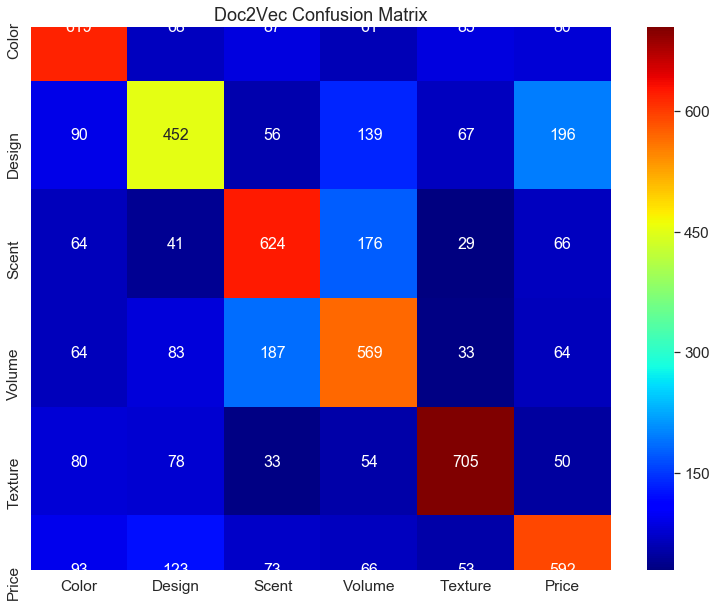

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(13, 10))
plt.title("Doc2Vec Confusion Matrix", fontsize=18)

sns.set(font_scale = 1.4)
sns.heatmap(test_df, fmt="d", cmap="jet", annot=True, annot_kws={"size": 16}) # font size

plt.show()

In [70]:
from sklearn.decomposition import PCA

# PCA 모델을 생성
pca = PCA(n_components=2) # 주성분 갯수
pca_train_result = pca.fit_transform(train_prediction) # PCA 적용

In [71]:
pca_train_df = pd.DataFrame(pca_train_result, columns=['r0', 'r1'])
y_train_df = pd.DataFrame(y_label, columns=['target'])
pca_train_df = pd.concat([pca_train_df, y_train_df], axis=1)

In [72]:
pca_train_df.head()

,r0,r1,target
0,-0.205938,-0.136666,3
1,-0.288708,-0.179452,3
2,0.510500,-0.177497,4
3,0.159145,-0.027230,0
4,-0.240350,-0.153746,2


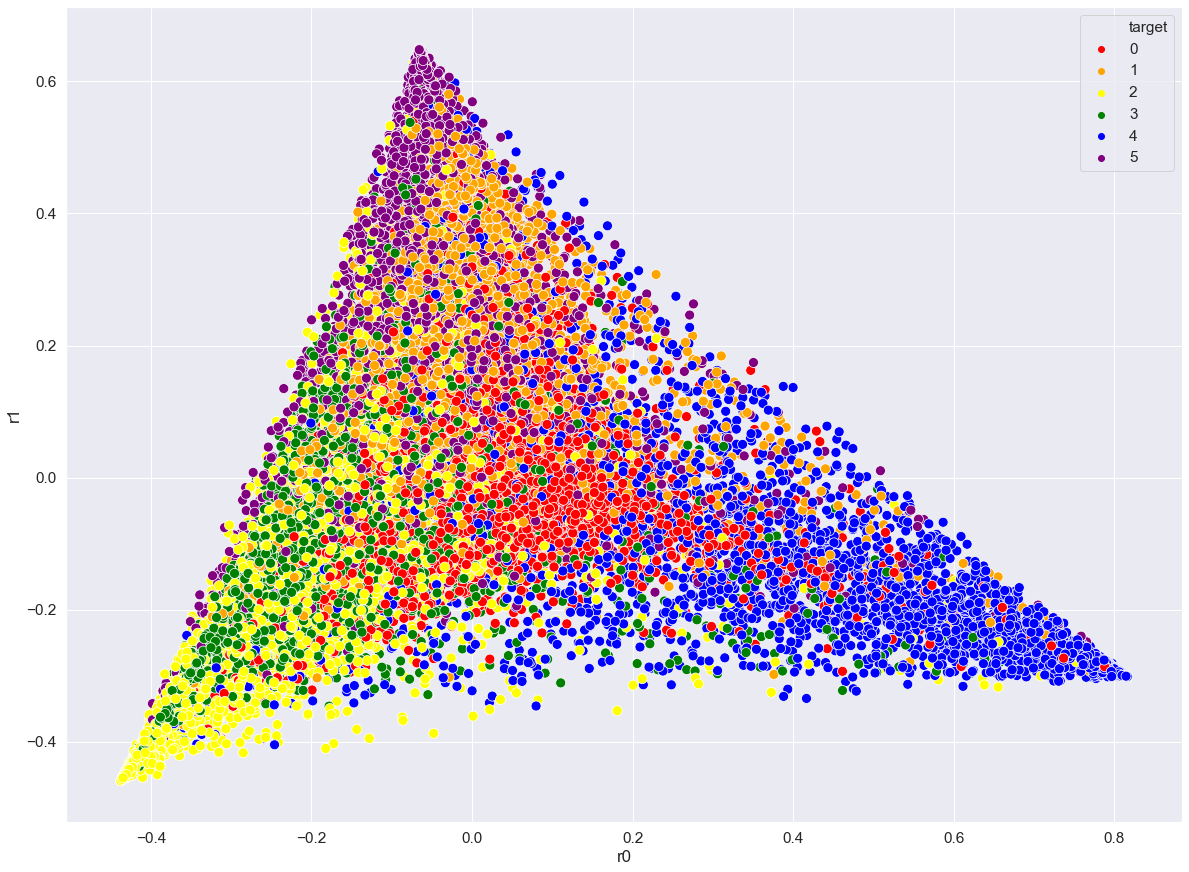

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20, 15))
sns.scatterplot(x='r0',
                y='r1',
                hue='target',
                s=100,
                palette=['red','orange','yellow','green','blue','purple'],
                data=pca_train_df)

plt.show()

In [74]:
# 테스트 시각화
pca_test_result = pca.transform(test_prediction) # PCA 적용

In [75]:
pca_test_df = pd.DataFrame(pca_test_result, columns=['r0', 'r1'])
y_test_df = pd.DataFrame(y_label, columns=['target'])
pca_test_df = pd.concat([pca_test_df, y_test_df], axis=1)

In [76]:
pca_test_df.head()

,r0,r1,target
0,-0.205974,-0.184809,3
1,-0.005976,-0.022745,3
2,0.241542,-0.046253,4
3,0.121519,0.141838,0
4,-0.315909,-0.270636,2


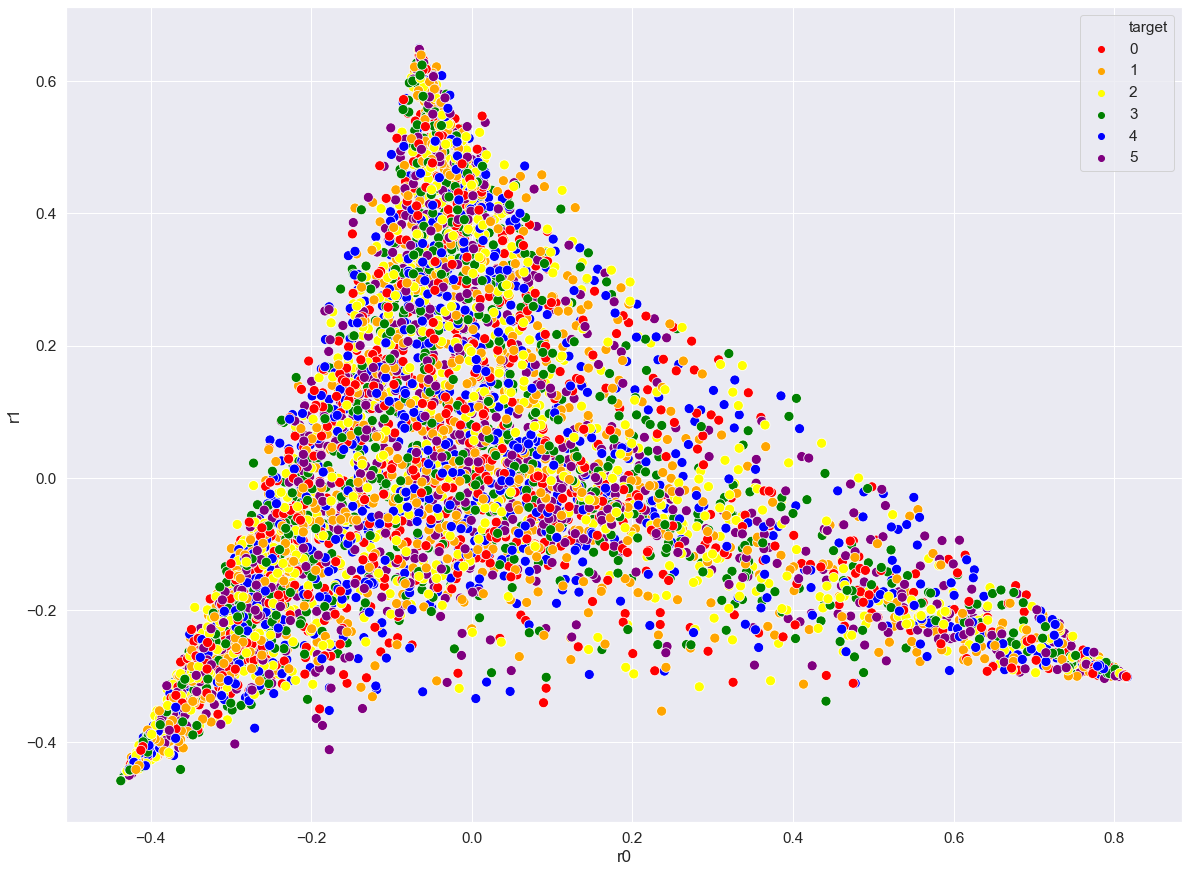

In [77]:
plt.figure(figsize=(20, 15))
sns.scatterplot(x='r0',
                y='r1',
                hue='target',
                s=100,
                palette=['red','orange','yellow','green','blue','purple'],
                data=pca_test_df)

plt.show()